# VAE + LSTM with One-Hot encoding for text generation and anomaly detection

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import string
import pickle
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from keras.layers import Input, Dense, Lambda, Layer, LSTM, RepeatVector, Embedding, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import metrics
from keras import objectives
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import seaborn as sns

## Load Text Data

In [0]:
# load training data

print("- Training data")
with open ('drive/Seminar/data/reviews_0.pickle', 'rb') as f:
  data = pickle.load(f)
print("Total length: ", len(data))

sentences = data.lower()
sentences = sentences.replace('!','.').replace('?','.').replace('\n','.').split('.')
sentences = [x.translate(str.maketrans("", "", string.punctuation)) for x in sentences if len(x.split())==10]
X = sentences[:100000]
print("Filtered senteces: ", len(X))


#load positive data (reviews)

print("\n- Positive data")
with open ('drive/Seminar/data/reviews_1.pickle', 'rb') as f:
  data = pickle.load(f)
print("Total length: ", len(data))

sentences = data.lower()
sentences = sentences.replace('!','.').replace('?','.').replace('\n','.').split('.')
sentences = [x.translate(str.maketrans("", "", string.punctuation)) for x in sentences if len(x.split())==10]
pos_X = sentences[:10000]
print("Filtered senteces: ", len(pos_X))


#load negative data (news headlines)
      
print("\n- Negative data")
with open ('drive/Seminar/data/news.pickle', 'rb') as f:
  data = pickle.load(f)
print("Total length: ", len(data))

sentences = data.lower()
sentences = sentences.replace('!','.').replace('?','.').replace('\n','.').split('.')
sentences = [x.translate(str.maketrans("", "", string.punctuation)) for x in sentences if len(x.split())==10]
neg_X = sentences[:10000]
print("Filtered senteces: ", len(neg_X))


#load semi negative data (food reviews)
      
print("\n- Semi negative data")
with open ('drive/Seminar/data/food_reviews.pickle', 'rb') as f:
  data = pickle.load(f)
print("Total length: ", len(data))

sentences = data.lower()
sentences = sentences.replace('!','.').replace('?','.').replace('\n','.').split('.')
sentences = [x.translate(str.maketrans("", "", string.punctuation)) for x in sentences if len(x.split())==10]
semi_X = sentences[:10000]
print("Filtered senteces: ", len(semi_X))

- Training data
Total length:  161252581
Filtered senteces:  94369

- Positive data
Total length:  161252581
Filtered senteces:  10000

- Negative data
Total length:  47660662
Filtered senteces:  10000

- Semi negative data
Total length:  114788133
Filtered senteces:  10000


In [0]:
max_words = 1500
max_len = 10

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(np.concatenate([X, pos_X, neg_X, semi_X]))
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

reverse_word_map = dict(map(reversed, tok.word_index.items()))
reverse_word_map[0] = ''

def print_sentence(sequence):
  res = ' '.join([reverse_word_map[x] for x in sequence])
  print(res)

In [0]:
sequences_matrix = to_categorical(sequences_matrix, num_classes=max_words)

train = sequences_matrix[:80000]
test = sequences_matrix[80000:94000]

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (80000, 10, 1500)
Test shape:  (14000, 10, 1500)


 ## Variational Autoencoder with LSTM and One-Hot encoding

In [0]:
batch_size = 500
original_dim = max_len
latent_dim = 200
intermediate_dim = 500
epochs = 120
epsilon_std = 1.0

x = Input(shape=(original_dim, max_words))
h = LSTM(intermediate_dim)(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
      
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  
def xent_loss(y_true, y_pred):
  return original_dim * metrics.categorical_crossentropy(y_true, y_pred)

def mse_loss(y_true, y_pred):
  return original_dim * metrics.mse(y_true, y_pred)

def kl_loss(y_true, y_pred):
  return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(y_true, y_pred):
  xent_loss = K.mean(original_dim * metrics.categorical_crossentropy(y_true, y_pred))
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return K.mean(xent_loss + kl_loss)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = LSTM(intermediate_dim, return_sequences=True)
decoder_mean = Dense(max_words, activation='softmax')

h_decoded = RepeatVector(original_dim)(z)
h_decoded = decoder_h(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, [x_decoded_mean])
vae.compile(optimizer='adam', loss=[vae_loss], metrics=[xent_loss, mse_loss, kl_loss])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1500)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 500)          4002000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          100200      lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 200)          100200      lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_1 (

In [0]:
#checkpoint
cp = [ModelCheckpoint(filepath="drive/Seminar/models/vae_emb.h5", verbose=1, save_best_only=True)]

#train
history = vae.fit(train, train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test, test),
        callbacks=cp)

#save weights, model and history to file
vae.save_weights('drive/Seminar/models/vae_emb_weights.hdf5')

with open ('drive/Seminar/models/vae_emb.json', 'w') as json_file:
    json_file.write(vae.to_json())

with open ('drive/Seminar/models/history_emb.pickle', 'wb') as f:
    pickle.dump(history, f)

Train on 80000 samples, validate on 14000 samples
Epoch 1/120
80000/80000 [==============================] - 41s 508us/step - loss: 53.7324 - xent_loss: 51.9124 - mse_loss: 0.0061 - kl_loss: 1.8201 - val_loss: 49.8265 - val_xent_loss: 48.5794 - val_mse_loss: 0.0058 - val_kl_loss: 1.2472

Epoch 00001: val_loss improved from inf to 49.82653, saving model to drive/Seminar/models/vae_emb.h5
Epoch 2/120
80000/80000 [==============================] - 37s 459us/step - loss: 48.8585 - xent_loss: 47.6059 - mse_loss: 0.0057 - kl_loss: 1.2526 - val_loss: 48.3112 - val_xent_loss: 47.2436 - val_mse_loss: 0.0057 - val_kl_loss: 1.0676

Epoch 00002: val_loss improved from 49.82653 to 48.31124, saving model to drive/Seminar/models/vae_emb.h5
Epoch 3/120
80000/80000 [==============================] - 37s 459us/step - loss: 47.6367 - xent_loss: 46.8722 - mse_loss: 0.0057 - kl_loss: 0.7645 - val_loss: 47.4139 - val_xent_loss: 46.7407 - val_mse_loss: 0.0057 - val_kl_loss: 0.6732

Epoch 00003: val_loss impr

In [0]:
#load weights from file
#vae.load_weights('drive/Seminar/models/vae_emb_weights.hdf5')

In [0]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = RepeatVector(original_dim)(decoder_input)
_h_decoded = decoder_h(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

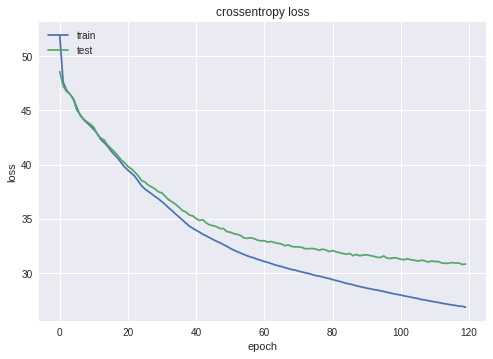

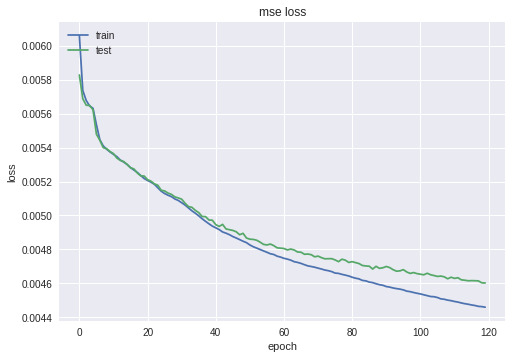

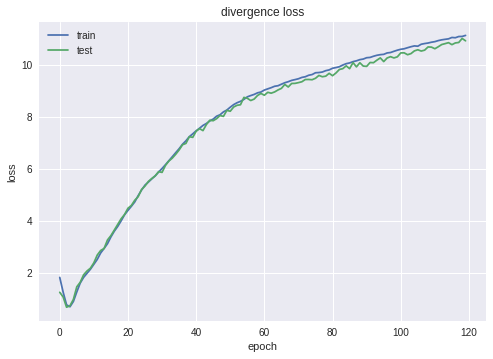

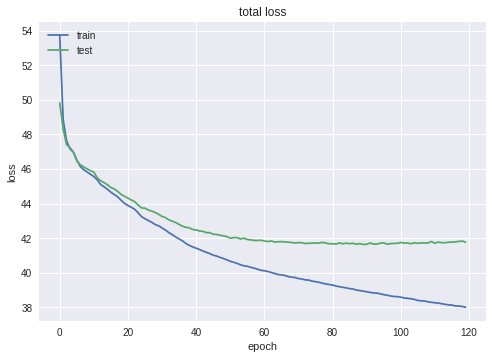

In [0]:
#with open ('drive/Seminar/data/history_emb.pickle', 'rb') as f:
    #history = pickle.load(f)

# summarize history for crossentropy loss
plt.plot(history.history['xent_loss'])
plt.plot(history.history['val_xent_loss'])
plt.title('crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for mse loss
plt.plot(history.history['mse_loss'])
plt.plot(history.history['val_mse_loss'])
plt.title('mse loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for divergence loss
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('divergence loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for total loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Generating Text From Latent Space

In [0]:
sample = sequences_matrix[:1000]
print(sample.shape)

sample_encoded = encoder.predict(sample)
sample_decoded = generator.predict(sample_encoded)

n_sentences = 1000
random = [np.random.normal(0., epsilon_std, latent_dim) for x in range(n_sentences)]
random = np.array(random).reshape(-1,latent_dim)
sample_generated = generator.predict(random)

(1000, 10, 1500)


In [0]:
# compare original and reconstructed sentence vectors
for i in range(20,30):
  print(np.argmax(sample[i],axis=1))
  print(np.argmax(sample_decoded[i],axis=1))
  print()

[  0   0   1 117   8   1  67   2  22 278]
[  0   0   1 999   8   1  67   2  22 278]

[  0   2 400   2  41  27  45  11   1 605]
[  0   2 104   2  41  27  45  11   1  53]

[  0   1 207   8  18   4  42  21  27 600]
[  0   1  67   8  18   4 195  21 112   4]

[  0   0  60   1 777 279   8 182 190  49]
[0 0 0 1 9 4 8 3 7 7]

[  0   0   0   6   8   1 199   9   1  28]
[  0   0   0   6   8   1  67   9   1 259]

[  7   6   8   3  28 425   5 398  17 251]
[  0   6   8   3  28 108   5 398   5   1]

[  0  29   2 121  12   3 574 831  10   1]
[ 0  0  2 12  5  3  1 15 16  1]

[  0   0  28 321 662 127 258  85   6 470]
[  0   0   3  15   5   1 258   9   1 117]

[  0   0   6  35  43   3 427  11   1 773]
[ 0  0  6 15  8  3 28 11  1 91]

[  2  46 103  11  19 180 109 283   3  15]
[   2   46   13 1175    6   15    5  283    6   15]



In [0]:
# compare original and reconstructed sentences

for i in range(20,30):
  print_sentence(np.argmax(sample[i],axis=1))
  print_sentence(np.argmax(sample_decoded[i],axis=1))
  print()

  the music is the best i have seen
  the content is the best i have seen

 i guess i will be more in the future
 i think i will be more in the time

 the worst is that it can t be returned
 the best is that it doesn t work it

  love the production everything is real nice out
   the of it is a and and

   this is the last of the great
   this is the best of the world

and this is a great place to start with him
 this is a great way to start to the

 all i got was a phone number for the
  i was to a the book on the

  great job played their whole album this night
  a book to the whole of the music

  this movie has a young in the lead
  this book is a great in the story

i would never in my life recommend such a book
i would not returning this book to such this book



In [0]:
# print generated sentences

for i in range(20,30):
  print_sentence(np.argmax(sample_generated[i],axis=1))

  the way on the box was on the
if you yourself this and in a waste of money
  save your the you want to get it
  i will have to buy this for anyone
   if you to it and the s
    i found the and and well
   at addition the are the and and
i did not wait it down if i bought it
  it was very large size and on the
  the of the the i have been better


## Evaluating Anomaly Score

In [0]:
pos_sequences = tok.texts_to_sequences(pos_X)
pos_sequences_matrix = sequence.pad_sequences(pos_sequences,maxlen=max_len)

pos_sequences_matrix = to_categorical(pos_sequences_matrix, num_classes=max_words)
print("Reviews (positive data) shape: ", pos_sequences_matrix.shape)

Reviews (positive data) shape:  (10000, 10, 1500)


In [0]:
pos_scores = {'loss': [], 'xent_loss': [], 'mse_loss': [], 'kl_loss': []}

for sample in pos_sequences_matrix:
  sample = sample.reshape(1,original_dim,max_words)
  scores = vae.evaluate(sample, sample, batch_size=1, verbose=0)
  pos_scores['loss'].append(scores[0])
  pos_scores['xent_loss'].append(scores[1])
  pos_scores['mse_loss'].append(scores[2])
  pos_scores['kl_loss'].append(scores[3])

In [0]:
neg_sequences = tok.texts_to_sequences(neg_X)
neg_sequences_matrix = sequence.pad_sequences(neg_sequences,maxlen=max_len)

neg_sequences_matrix = to_categorical(neg_sequences_matrix, num_classes=max_words)
print("News (negative data) shape: ", neg_sequences_matrix.shape)

News (negative data) shape:  (10000, 10, 1500)


In [0]:
neg_scores = {'loss': [], 'xent_loss': [], 'mse_loss': [], 'kl_loss': []}

for sample in neg_sequences_matrix:
  sample = sample.reshape(1,original_dim,max_words)
  scores = vae.evaluate(sample, sample, batch_size=1, verbose=0)
  neg_scores['loss'].append(scores[0])
  neg_scores['xent_loss'].append(scores[1])
  neg_scores['mse_loss'].append(scores[2])
  neg_scores['kl_loss'].append(scores[3])

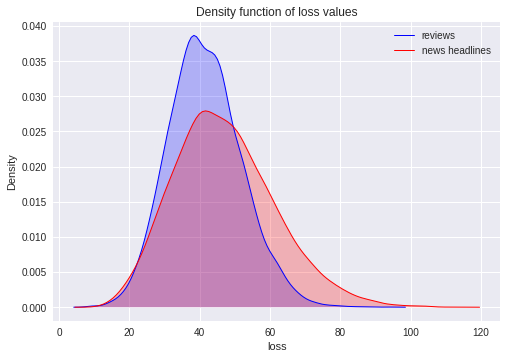

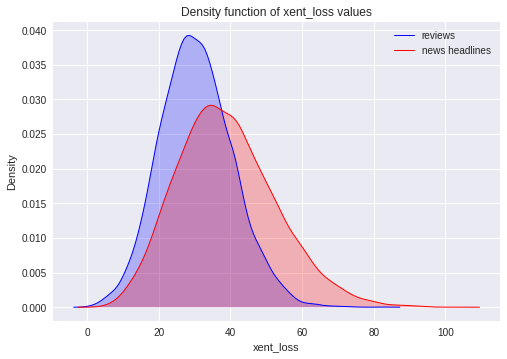

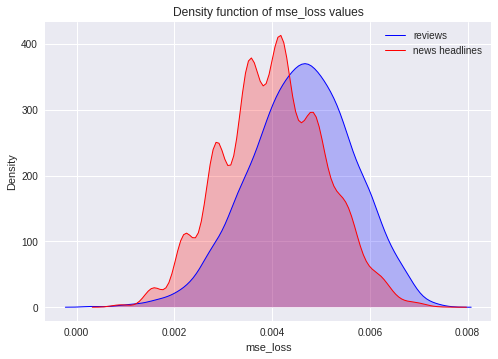

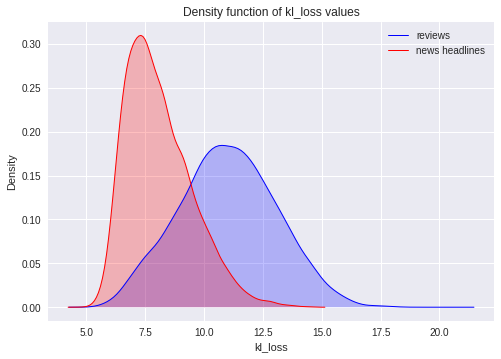

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  plt.figure()
  ax1 = sns.distplot(pos_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='reviews',color="blue")
  ax2 = sns.distplot(neg_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='news headlines', color= "red")



  plt.title('Density function of '+score+' values')
  plt.xlabel(score)
  plt.ylabel('Density')
  plt.legend()

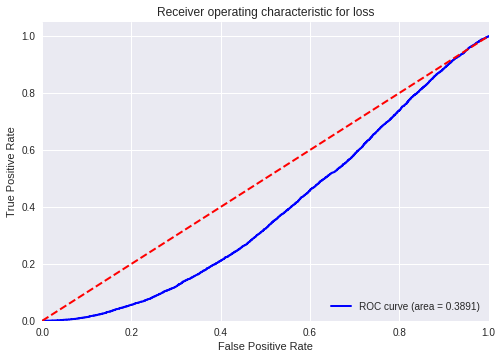

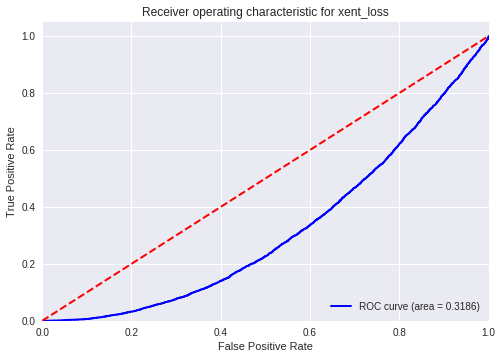

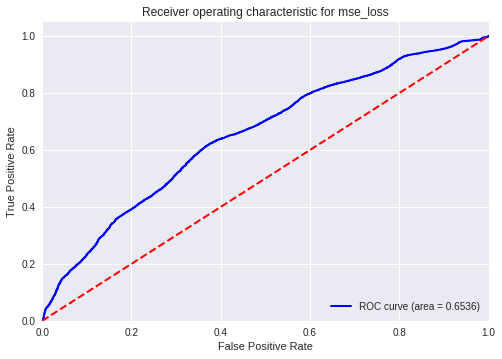

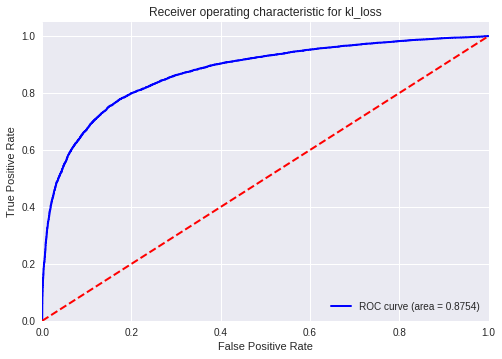

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  
  y_true_pos = np.ones(len(pos_scores[score]))
  y_true_neg = np.zeros(len(neg_scores[score]))
                        
  y_true = np.concatenate((y_true_pos, y_true_neg))
  y_pred = np.concatenate((pos_scores[score], neg_scores[score]))

  fpr, tpr, thresholds = skl.roc_curve(y_true, y_pred, pos_label=1)
  roc_auc = skl.auc(fpr, tpr)  
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='blue',
           lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for '+score)
  plt.legend(loc="lower right")
  plt.show()

## Regular Reviews vs Food Reviews

In [0]:
semi_sequences = tok.texts_to_sequences(semi_X)
semi_sequences_matrix = sequence.pad_sequences(semi_sequences,maxlen=max_len)

semi_sequences_matrix = to_categorical(semi_sequences_matrix, num_classes=max_words)
print("Food reviews (semi-negative data) shape: ", semi_sequences_matrix.shape)

Food reviews (semi-negative data) shape:  (10000, 10, 1500)


In [0]:
semi_scores = {'loss': [], 'xent_loss': [], 'mse_loss': [], 'kl_loss': []}

for sample in semi_sequences_matrix:
  sample = sample.reshape(1,original_dim,max_words)
  scores = vae.evaluate(sample, sample, batch_size=1, verbose=0)
  semi_scores['loss'].append(scores[0])
  semi_scores['xent_loss'].append(scores[1])
  semi_scores['mse_loss'].append(scores[2])
  semi_scores['kl_loss'].append(scores[3])

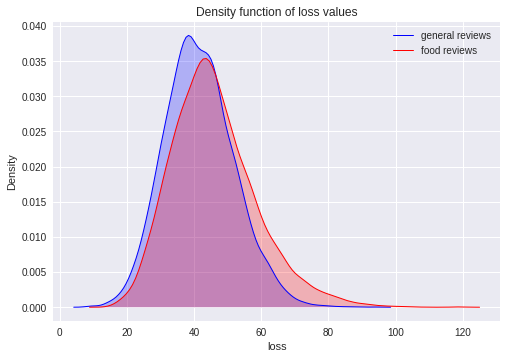

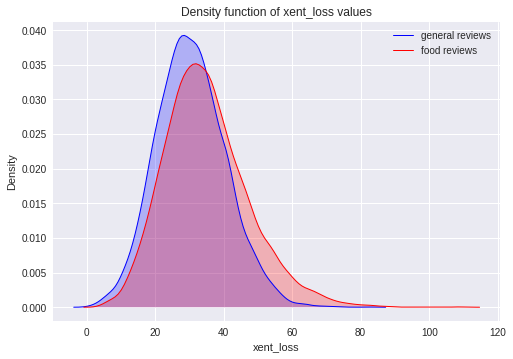

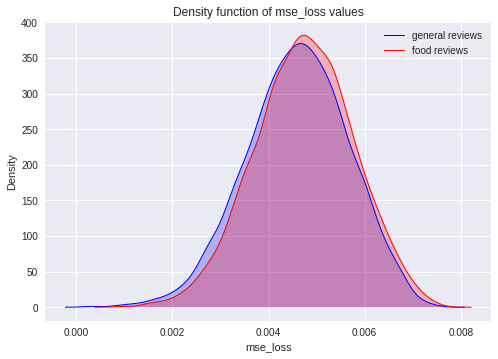

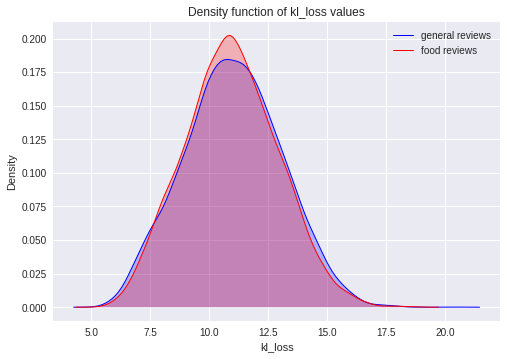

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  plt.figure()
  ax1 = sns.distplot(pos_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='general reviews',color="blue")
  ax2 = sns.distplot(semi_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='food reviews', color= "red")



  plt.title('Density function of '+score+' values')
  plt.xlabel(score)
  plt.ylabel('Density')
  plt.legend()

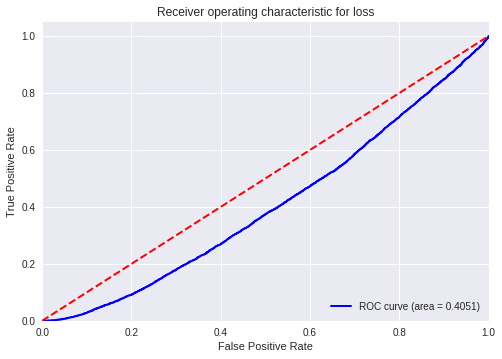

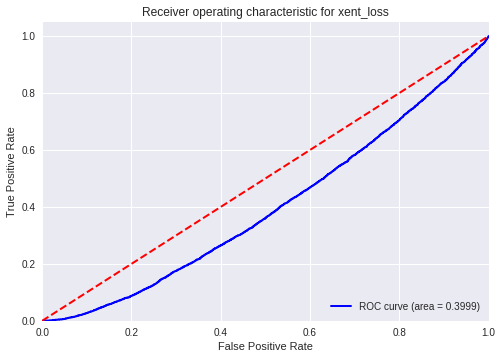

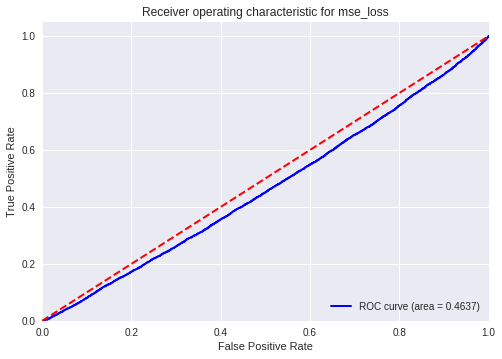

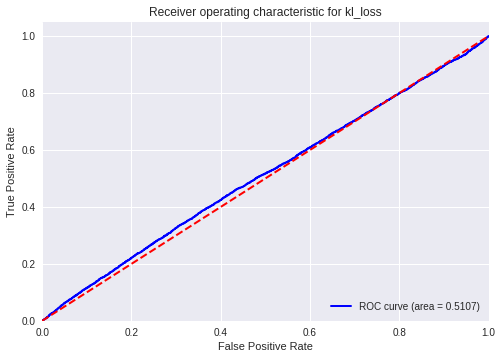

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  
  y_true_pos = np.ones(len(pos_scores[score]))
  y_true_semi = np.zeros(len(semi_scores[score]))
                        
  y_true = np.concatenate((y_true_pos, y_true_semi))
  y_pred = np.concatenate((pos_scores[score], semi_scores[score]))

  fpr, tpr, thresholds = skl.roc_curve(y_true, y_pred, pos_label=1)
  roc_auc = skl.auc(fpr, tpr)  
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='blue',
           lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for '+score)
  plt.legend(loc="lower right")
  plt.show()

## Print samples from loss distribution

In [0]:
# positive data (general reviews)

n = 10
ind = np.array(pos_scores['loss']).argsort()
pos_sequence_ordered = pos_sequences_matrix[ind]
middle = int(len(pos_sequence_ordered)/2)

print("Low loss samples:")
for s in pos_sequence_ordered[100:100+n]:
  print_sentence(np.argmax(s,axis=1))
  
print("\nAverage loss samples:")
for s in pos_sequence_ordered[middle-int(n/2):middle+int(n/2)]:
  print_sentence(np.argmax(s,axis=1))
  
print("\nHigh loss samples:")
for s in pos_sequence_ordered[-n:]:
  print_sentence(np.argmax(s,axis=1))

Low loss samples:
do not waste your time and money on this product
    i love all of s books
    i d recommend it for and
      that is s the
      and with very and
    the plot is and the is
      the for and its
     this product is a for
  i wouldn t recommend this to my worst
 do not waste your time or money on this

Average loss samples:
the first day it came out and i love it
 i have lost one of them from my left
 i was with the writing style and story line
   the is weird and the print small
  i am so sick of doing this to
 and this film made me that i was right
 the thing is impossible to out how to use
 we put it on her and she stopped immediately
 i stopped at page and threw the book away
however they are listed on the side of the box

High loss samples:
truth be told truth be told this game is terrible
they give awesome shows too saw them 4 times already
put the movie into my sony bluray and got sound
you cannot start trial 1 until you are level 40
 another government progr

In [0]:
# negative data (news headlines)

n = 10
ind = np.array(neg_scores['loss']).argsort()
neg_sequence_ordered = neg_sequences_matrix[ind]
middle = int(len(neg_sequence_ordered)/2)

print("Low loss samples:")
for s in neg_sequence_ordered[100:100+n]:
  print_sentence(np.argmax(s,axis=1))
  
print("\nAverage loss samples:")
for s in neg_sequence_ordered[middle-int(n/2):middle+int(n/2)]:
  print_sentence(np.argmax(s,axis=1))
  
print("\nHigh loss samples:")
for s in neg_sequence_ordered[-n:]:
  print_sentence(np.argmax(s,axis=1))

Low loss samples:
      to for in the
        with i
      and a from the
       out of with
        is called
      a of a on
        at to
       of of home
        down from
        through of

Average loss samples:
    says to be felt for years
   to in for up to six weeks
    an new pm looks to up
     agree on i for talks
   group to try and take out of
    to step down as after common
   kevin on just water off a back
    a has been sold to coal
   the at continue to grow thanks to
     nt govt to in on

High loss samples:
 labor minister happy to leave election date to premier
n korea and s korea hold first talks in years
 states urged to follow sa lead on sex laws
us calls on north korea to give date for talks
group to meet in north west wa over rock art
govt under fire over a g report into sa water
sa health minister john hill says the message of a
first cut hear health minister john hill tell of a
us not un to lead in post war iraq rice
 wa govt urged to meet local govt over

In [0]:
# semi-negative data (food reviews)

n = 10
ind = np.array(semi_scores['loss']).argsort()
semi_sequence_ordered = semi_sequences_matrix[ind]
middle = int(len(semi_sequence_ordered)/2)

print("Low loss samples:")
for s in semi_sequence_ordered[100:100+n]:
  print_sentence(np.argmax(s,axis=1))
  
print("\nAverage loss samples:")
for s in semi_sequence_ordered[middle-int(n/2):middle+int(n/2)]:
  print_sentence(np.argmax(s,axis=1))
  
print("\nHigh loss samples:")
for s in semi_sequence_ordered[-n:]:
  print_sentence(np.argmax(s,axis=1))

Low loss samples:
    i love this on my and
  the is the best we have ever had
    i first got the in the
    there s a good between and
   i don t even get the to
      these are real in
   i d definitely recommend this to anyone
    this is great and so good
    it s a blend of and
  if you like you ll love it too

Average loss samples:
   anyway our is looking for another brand
   amazing and no or should go without
  we made using this and were very impressed
  i love the and value of and save
 i ll be returning the extra pack i bought
   thank you for this fantastic coffee choice
   i think for sweet i prefer real
 they make great and would definitely buy them again
  it looks like someone stuck a in some
  all it is some water and or oil

High loss samples:
br br please forward that information as soon as possible
 br br my two favorite flavors are vanilla and
br br they arrived and my little guy loves them
local stores only carry 3 flavors 11 in this one
br br i only wish amazon